In [38]:
import librosa 
import numpy as np
import pandas as pd
import os

max = 0

def mel_extraction(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        if len(audio)/sample_rate > 2:
            audio = audio[ : sample_rate*2]
            
        S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64, hop_length=512)
        log_S = librosa.power_to_db(S, ref=np.max)
        global max
        if log_S.shape[1] > max:
            max = log_S.shape[1]

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return log_S

In [39]:
# 데이터셋 path 지정
fulldatasetpath = "C:\\Users\\taemi\\capstone\\data\\1_default\\sounddata"
metadata = pd.read_csv("C:\\Users\\taemi\\capstone\\data\\1_default\\metadata_2.csv")

features = []

    
# 각 소리에 대해 feature를 추출
for index, row in metadata.iterrows():
    
    filename = os.path.join(os.path.abspath(fulldatasetpath)+'/'+str(row["filename"]))
    classname = row["class"]
    data = mel_extraction(filename)
    
    features.append([data, classname])
    

featuresdf = pd.DataFrame(features, columns=['feature','class'])

print('Finished feature extraction from ', len(featuresdf), ' files') 
print('Max :',max)


C:\Users\taemi\anaconda3\envs\py38\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Finished feature extraction from  2978  files
Max : 87


Class=babycry, n=400 (13.432%)
Class=glassbreak, n=400 (13.432%)
Class=meow, n=320 (10.745%)
Class=carhorn, n=400 (13.432%)
Class=dogbark, n=400 (13.432%)
Class=siren, n=400 (13.432%)
Class=knock, n=300 (10.074%)
Class=scream, n=358 (12.021%)


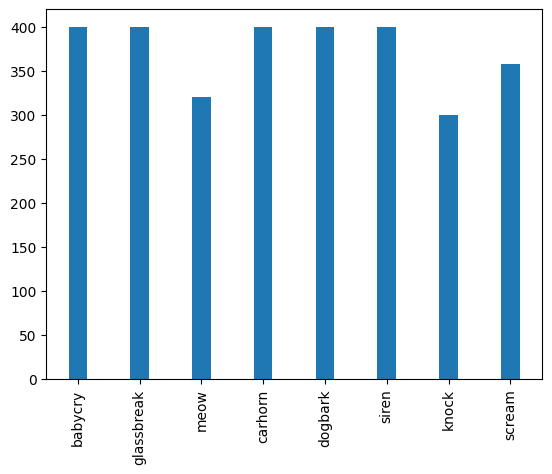

358

In [41]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot

#클래스별 데이터 갯수 표로 표시
data = featuresdf.values
y = data[:, -1]

def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%s, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values(), width=0.3)
    pyplot.xticks(np.arange(0,8), labels=counter.keys(), rotation=90)
    pyplot.show()
    
    return v

data = featuresdf.values
y = data[:, -1]

count_and_plot(y)

In [42]:
# extract feature 함수 재정의
import numpy as np
import librosa.display
max_pad_len = 87
test_num = 0

def mel_extraction(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
        
        if len(audio)/sample_rate > 2:
            audio = audio[ : sample_rate*2]
            
        S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=64, hop_length=512)
        log_S = librosa.power_to_db(S, ref=np.max)
        pad_width = max_pad_len - log_S.shape[1]
        log_S = np.pad(log_S, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
  
    except Exception as e:
        print("Error 발생: ", file_name)
        return None
    
    
    return log_S

In [43]:
import os

# 데이터셋 path 지정
fulldatasetpath = "C:\\Users\\taemi\\capstone\\data\\1_default\\sounddata"

metadata = pd.read_csv("C:\\Users\\taemi\\capstone\\data\\1_default\\metadata_2.csv")

features = []

# 각 소리에 대해 feature를 추출
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath)+'/'+str(row["filename"]))
    classname = row['class']
    data = mel_extraction(file_name)
        
        
    features.append([data, classname])
   
 


featuresdf = pd.DataFrame(features, columns=['feature','class'])
print('Finished feature extraction from ', len(featuresdf), ' files') 

C:\Users\taemi\anaconda3\envs\py38\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Finished feature extraction from  2978  files


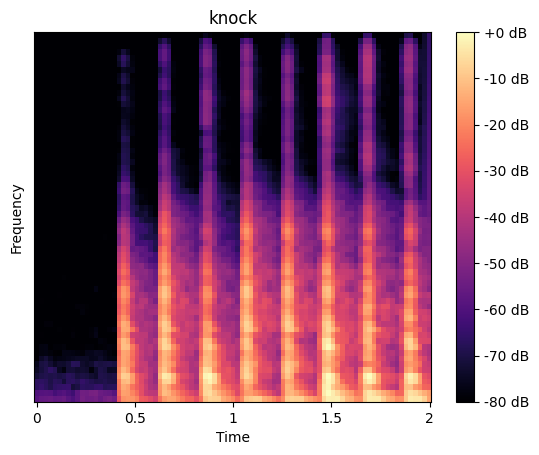

In [44]:
import librosa.display
from matplotlib import pyplot as plt

plt.figure()
librosa.display.specshow(featuresdf['feature'][300], sr = 22050, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(featuresdf['class'][300])
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd


# Pandas로 저장된 각 열을 np.array로 반환
# X는 MFCC의 데이터
X = np.array(featuresdf.feature.tolist())
# Y는 그 데이터의 Label이 저장됨
y = np.array(featuresdf['class'].tolist())

# Tensorflow에 Label이 사용될 수 있도록 Label을 숫자로 인코딩 해준다.
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# Test 데이터와 Train 데이터로 2:8로 나눈다.(셔플값이 디폴트이기 때문에 굳이 설정안해도 됨)
x_train, x_val, y_train, y_val = train_test_split(X, yy, test_size=0.1, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.12222, random_state=1)

In [46]:
num_rows = 64
num_columns = 87
num_channels = 1

print("train data shape")
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
x_val = x_val.reshape(x_val.shape[0], num_rows, num_columns, num_channels)

print("\ntrain data reshape 결과")
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

train data shape
(2352, 64, 87)
(328, 64, 87)
(298, 64, 87)

train data reshape 결과
(2352, 64, 87, 1)
(328, 64, 87, 1)
(298, 64, 87, 1)


In [47]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Dropout,LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from sklearn import metrics

num_labels = yy.shape[1]
filter_size = 2

# HyperParameter
EPOCHS = 1000
BATCH_SIZE = 512
MODEL_SAVE = "C:\\Users\\taemi\\capstone\\best_weight_model"
if not os.path.exists(MODEL_SAVE):
    os.mkdir(MODEL_SAVE)
    
checkpoint = ModelCheckpoint(filepath="{}/default4.h5".format(MODEL_SAVE), monitor="val_loss",
                             verbose=1, save_best_only=True)

ealrystopping = EarlyStopping(monitor="val_loss", patience=20)

#CNN모델 구현
model = Sequential([
    Conv2D(16, 4, padding="same", input_shape=(num_rows, num_columns, num_channels), activation=LeakyReLU(0.1)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 1, activation="relu"),
    Conv2D(64, 2, activation="relu"),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 4, activation=LeakyReLU(0.1)),
    MaxPooling2D(),
    Dropout(0.2),
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(1024, activation="relu"),
    Dropout(0.2),
    Dense(num_labels, activation="softmax")])



#컴파일
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')  
model.summary()
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val),
          callbacks=[checkpoint, ealrystopping], verbose=1)

score = model.evaluate(x_test, y_test, verbose = 1)
accuracy = 100 * score[1]

print('Pre-training accuracy: %.4f%%' % accuracy)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 87, 16)        272       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 43, 16)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 32, 43, 16)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 43, 32)        544       
                                                                 
 conv2d_19 (Conv2D)          (None, 31, 42, 64)        8256      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 21, 64)       0         
 2D)                                                  

Training Accuracy:  98.2568 %
Validation Accuracy:  96.30873 %
Test Accuracy:  93.29268 %


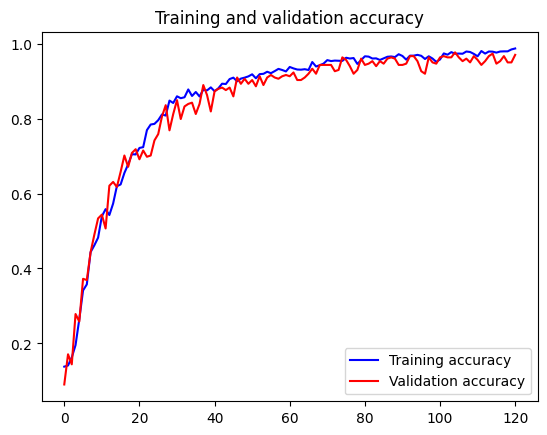

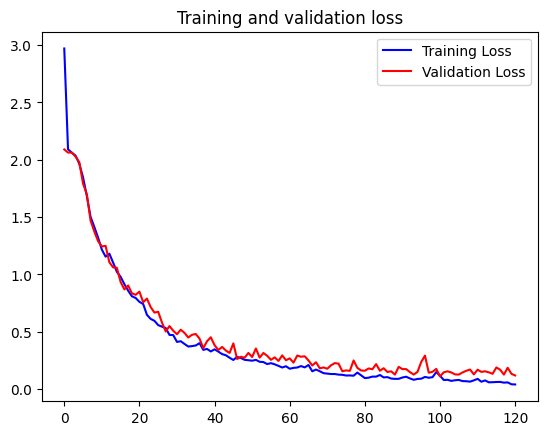

In [48]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
model = load_model("C:\\Users\\taemi\\capstone\\best_weight_model\\default4.h5")
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", round(score[1]*100, 5), "%")
score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", round(score[1]*100, 5), "%")
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: ", round(score[1]*100, 5), "%")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:


def print_prediction(file_name):
    prediction_feature = mel_extraction(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)
    
    y_prob = model.predict(prediction_feature)
    predicted_vector = y_prob.argmax(axis=-1)
    
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 


    predicted_proba_vector = model.predict(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [50]:
def predict_prob(number):
  return [number[0],1-number[0]]

In [58]:
filename = 'C:\\Users\\taemi\\Documents\\소리 녹음\\knock2.wav'
print_prediction(filename) 

1/1 [==============================] - 0s 13ms/step
The predicted class is: knock 

1/1 [==============================] - 0s 13ms/step
babycry 		 :  0.00000000003439105944469389442020
carhorn 		 :  0.00000000010846077508341878115061
dogbark 		 :  0.00000001287722373177757617668249
glassbreak 		 :  0.00000003240787194158656348008662
knock 		 :  0.99999904632568359375000000000000
meow 		 :  0.00000095798588972684228792786598
scream 		 :  0.00000000002297782623894573106327
siren 		 :  0.00000000157479718154718284495175
